<a href="https://colab.research.google.com/github/brunobro/novel-approach-to-cowpea-cultivar-selection/blob/main/ANovelApproachToCowpeaCultivarSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**A Novel Approach to Cowpea Cultivar Selection: Integrating Silicon Nutrition and Computational Techniques**

Employ methods proposed in https://www.mdpi.com/2223-7747/11/21/2827/htm and https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0292076

**Authors:** Bruno Rodrigues de Oliveira1*, Wallace de Sousa Leite2, Rafael de Souza Miranda3, Alexson Filgueiras Dutra4, Mohammad K. Okla5, Renato Lustosa Sobrinho6, Milena Rodrigues Luz7, Alan Mario Zuffo8, Ricardo Silva de Sousa9, Maurisrael de Moura Rocha9, Hamada Abdelgawad10, Francisco de Alcântara Neto9*

1 Pantanal Editora, Nova Xavantina, MT, Brazil;

2 Federal Institute of Piauí, Uruçuí, PI, Brazil;

3 Postgraduate Program in Agricultural Sciences, Federal University of Piauí, Bom Jesus, PI, Brazil;

4 Federal Institute of Tocantins, Pedro Afonso, TO, Brazil;

5 Botany and Microbiology Department, College of Science, King Saud University, Riyadh 11451, Saudi Arabia;

6 Department of Agronomy, Federal Technological University of Paraná, Pato Branco, PR, Brazil;

7 Graduate in Forestry Engineering, Federal University of Piauí, Bom Jesus, PI, Brazil;

8 State University of Maranhão, Balsas, MA, Brazil;

9 Postgraduate Program in Agronomy, Federal University of Piauí, Teresina, PI, Brazil;

10 Integrated Molecular Plant Physiology Research, Department of Biology, University of Antwerp, 2020 Antwerp, Belgium;

**Corresponding author:** bruno@editorapantanal.com.br; fneto@ufpi.edu.br











In [ ]:
import numpy as np
import pandas as pd

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
#import statsmodels.api as sm
#from statsmodels.formula.api import ols

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

from scipy.spatial import distance

In [ ]:
# Library researchpy
#https://pypi.org/project/researchpy/
#!pip install researchpy
#import researchpy as rp

# Library: Pingoin
# https://pypi.org/project/pingouin/
#!pip install pingouin
#import pingouin as pg

#Library Python-Docx
#Documentation: https://python-docx.readthedocs.io/en/latest/
!pip install python-docx

import docx
from docx.shared import Pt
from docx.enum.table import WD_TABLE_ALIGNMENT, WD_ALIGN_VERTICAL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184487 sha256=88533dfb00a86165b561c4c0c7ab816cacbe8f93a9192fe91bcea6fd341c7a97
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx


In [ ]:
#Function to convert table for MS Word
def convert_MSWord(df, name_doc, n_dig=4):

    doc = docx.Document()

    n_rows = df.shape[0]
    n_cols = df.shape[1]
    table = doc.add_table(rows=n_rows + 1, cols=n_cols)
    for col_ins, col_label in enumerate(df):
        for row_ins in np.arange(-1, n_rows, 1):
            cell_ = table.cell(row_ins + 1, col_ins)
            if row_ins == -1:
                cell_.text = df.columns[col_ins]
            else:
                v = df[col_label][row_ins]
                if isinstance(v, float) or isinstance(v, int):
                    v = np.around(v, n_dig)

                cell_.text = str(v)

    #Store
    doc.save(name_doc + '.docx')

# Load data

In [ ]:
'''
According to the ANOVA test performed in SISVAR, the following variables are statistically significant,
in relation to interation: Water regime x Silicon x Cultivar

LA = leaf area
SFM = aerial fresh mass
SDM = aerial dry mass
PDM = plant dry mass
RST = relative stress tolerance
LS = leaf succulence
RWC = relative water content
CHL_a = chlorophyll a
CHL_b = chlorophyll b
A = net photosynthesis
E = transpiration rate
Gs = stomatal conductance
A_Ci = instantaneous carboxylation efficiency (A/Ci)
A_E = instantaneous water use efficiency (A/E)
A_Gs = intrinsic water use efficiency (A/gs)
'''

#Variables
Vars = ["LA", "SFM", "SDM", "PDM", "RST", "LS", "RWC", "Chl_a", "Chl_b", "A", "E", "Gs", "A_Ci", "A_E", "A_gs"]

#Read data for the above variables more 'Class', 'Cultivar', 'Silicon'
df = pd.read_excel('data.xlsx')
df = df[['Class', 'Cultivar', 'Silicon'] + Vars]

print('Raw data')
display(df)

Raw data


,Class,Cultivar,Silicon,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,Control,TUMUCUMAQUE,0,1881.20,128.73,16.645697,20.672697,100.000000,3.248209,60.853851,7089.109489,4821.321168,12.039140,1.530225,0.057600,0.105606,7.867562,209.013029
1,Control,TUMUCUMAQUE,0,1613.20,90.76,12.927478,14.532478,100.000000,2.265592,69.099074,8438.507726,6077.898455,15.179090,2.002353,0.076829,0.125447,7.580626,197.570441
2,Control,TUMUCUMAQUE,0,2179.50,126.43,14.655347,16.544347,100.000000,2.940567,72.338490,7657.613546,5093.043825,13.609115,5.637117,0.140000,0.057711,2.414198,200.000000
3,Control,TUMUCUMAQUE,1,1473.60,90.87,11.314577,12.228577,100.000000,2.846731,72.996109,6201.428571,5690.636364,13.860110,2.157879,0.077710,0.101169,6.423025,178.356862
4,Control,TUMUCUMAQUE,1,1671.81,106.23,11.403406,12.570406,100.000000,2.745144,61.905979,8227.495726,3970.529915,16.930000,1.581895,0.055635,0.148031,10.702354,304.304516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Severe,NOVAERA,2,461.10,26.27,3.325571,3.840571,30.014181,2.774979,52.284264,4909.792157,230.100000,2.220000,0.442821,0.013454,0.006210,5.013317,165.005218
104,Severe,NOVAERA,2,734.80,48.76,6.525363,6.868363,58.893166,3.223821,38.279570,8346.736842,920.000000,2.130000,0.588490,0.012079,0.005023,3.619435,176.336619
105,Severe,NOVAERA,4,580.50,41.92,4.931979,5.230979,44.592935,2.837213,45.470383,5029.723636,200.450000,2.287666,0.535092,0.017539,0.013068,4.275274,130.431084
106,Severe,NOVAERA,4,443.50,33.19,3.850742,4.328742,34.816832,2.941208,50.816993,4085.050746,28.871642,2.300000,0.767276,0.018863,0.007014,2.997616,121.934345


# Format dataset

In [ ]:
'''
Format dataset and normalize
'''
# Normalizes each variable (columns of dataframe)
# columun_cult_norm = column_cult / sum(column) where column_cult is the value os
# variable for a cultivar, sum(column) sum the values of variables for all
# cultivars
def norm(df):
    df = df.copy() #Avoid overriding the original dataframe
    for col in Vars:
        df[col] = df[col] / df[col].sum()
    return df

#Silicion level
si_levels   = [0, 1, 2, 4]
df_si_level = []

for si_level in si_levels:
    df_si = df[df['Silicon'] == si_level]
    del df_si['Silicon'] #Not used after separate
    df_si_level.append(df_si)

#Cultivars
cultivars = np.unique(df['Cultivar'])

df_controls  = []
df_moderates = []
df_severes   = []

df_controls_  = []
df_moderates_ = []
df_severes_   = []

# For Silicion level
for i, df_si in enumerate(df_si_level):

    print('\n>>> Silicon level: ', si_levels[i], '\n')

    #Split by class
    df_control_  = df_si[df_si['Class'] == 'Control']
    df_moderate_ = df_si[df_si['Class'] == 'Moderate']
    df_severe_   = df_si[df_si['Class'] == 'Severe']

    #Calculate the average value of experiments for raw data
    df_control_  = df_control_.groupby(['Cultivar'], as_index=False).mean(numeric_only=True)
    df_moderate_ = df_moderate_.groupby(['Cultivar'], as_index=False).mean(numeric_only=True)
    df_severe_   = df_severe_.groupby(['Cultivar'], as_index=False).mean(numeric_only=True)

    # Raw data
    df_controls_.append(df_control_)
    df_moderates_.append(df_moderate_)
    df_severes_.append(df_severe_)

    #Convert to MS Word - Raw data
    #convert_MSWord(df_control_, 'raw_control' + str(si_levels[i]))
    #convert_MSWord(df_moderate_, 'raw_moderate' + str(si_levels[i]))
    #convert_MSWord(df_severe_, 'raw_severe' + str(si_levels[i]))

    '''
    Normalize
    '''
    control_norm  = norm(df_control_[Vars])
    moderate_norm = norm(df_moderate_[Vars])
    severe_norm   = norm(df_severe_[Vars])

    df_control  = df_control_.copy()
    df_moderate = df_moderate_.copy()
    df_severe   = df_severe_.copy()

    df_control.iloc[:,1:]  = control_norm
    df_moderate.iloc[:,1:] = moderate_norm
    df_severe.iloc[:,1:]   = severe_norm

    #Normalized data
    df_controls.append(df_control)
    df_moderates.append(df_moderate)
    df_severes.append(df_severe)

    #Show an example for understand
    print('Raw data')
    display(df_moderate_)

    print('\n')
    print('Normalized data')
    display(df_moderate)


>>> Silicon level:  0 

Raw data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,412.150000,27.93,2.793412,3.106912,19.561710,2.729254,77.693259,6538.953764,3680.238464,2.602299,0.646588,0.021577,0.016446,4.225496,123.535975
1,TUMUCUMAQUE,887.933333,47.13,6.251090,7.287756,42.525463,2.764669,69.655266,6474.524225,2623.340787,11.469200,2.843042,0.071779,0.073912,4.069534,115.439357
2,XIQUEXIQUE,892.900000,52.87,5.542388,6.600055,49.441465,2.796958,83.722375,5138.768058,1547.133151,11.146669,2.420605,0.056397,0.049858,4.547071,148.242130




Normalized data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,0.187940,0.218323,0.191502,0.182816,0.175396,0.329187,0.336231,0.360228,0.468778,0.103191,0.109401,0.144087,0.117292,0.329035,0.319035
1,TUMUCUMAQUE,0.404897,0.368405,0.428542,0.428825,0.381296,0.333459,0.301445,0.356679,0.334153,0.454799,0.481037,0.479314,0.527130,0.316890,0.298125
2,XIQUEXIQUE,0.407162,0.413273,0.379957,0.388359,0.443307,0.337354,0.362323,0.283093,0.197069,0.442009,0.409562,0.376599,0.355579,0.354075,0.382839



>>> Silicon level:  1 

Raw data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,605.866667,38.530000,4.814200,5.434866,43.449456,2.877503,72.034117,6592.184881,4179.290608,9.700394,2.345656,0.070400,0.055935,4.487992,154.767923
1,TUMUCUMAQUE,782.800000,50.450000,5.651265,6.227265,45.945244,3.274454,78.874850,5900.786671,2626.696142,2.742833,1.430426,0.047436,0.010904,2.018281,59.993126
2,XIQUEXIQUE,736.533333,47.603333,4.250572,4.930906,38.641566,2.976049,65.759868,6217.138470,3034.863348,1.231963,2.020056,0.045370,0.008271,0.700222,122.736330




Normalized data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,0.285087,0.282099,0.327140,0.327539,0.339353,0.315239,0.332462,0.352333,0.424688,0.709343,0.404693,0.431358,0.744708,0.622770,0.458575
1,TUMUCUMAQUE,0.368342,0.369372,0.384021,0.375294,0.358846,0.358726,0.364034,0.315380,0.266918,0.200570,0.246790,0.290651,0.145177,0.280064,0.177759
2,XIQUEXIQUE,0.346571,0.348530,0.288839,0.297167,0.301802,0.326035,0.303504,0.332288,0.308394,0.090087,0.348518,0.277991,0.110116,0.097165,0.363666



>>> Silicon level:  2 

Raw data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,1240.750000,72.015000,8.797804,9.524304,85.415576,2.548976,75.229746,7328.527772,3808.459243,11.160410,2.817219,0.090873,0.065169,3.996396,122.988714
1,TUMUCUMAQUE,1005.486667,63.946667,6.990106,7.704106,56.235768,3.293460,75.076277,5930.821280,2695.229480,8.425389,1.866090,0.056858,0.048036,5.579675,176.706641
2,XIQUEXIQUE,730.200000,46.776667,4.961614,5.754948,35.567129,3.087123,63.753503,6045.777708,1932.472104,7.468378,2.519617,0.066389,0.043780,2.954578,139.136357




Normalized data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,0.416858,0.394088,0.424000,0.414400,0.481979,0.285454,0.351443,0.379616,0.451445,0.412521,0.391121,0.424403,0.415132,0.318930,0.280264
1,TUMUCUMAQUE,0.337816,0.349936,0.336880,0.335204,0.317325,0.368827,0.350726,0.307215,0.319485,0.311427,0.259074,0.265543,0.305989,0.445282,0.402675
2,XIQUEXIQUE,0.245327,0.255976,0.239119,0.250396,0.200697,0.345719,0.297831,0.313170,0.229070,0.276053,0.349805,0.310053,0.278879,0.235788,0.317061



>>> Silicon level:  4 

Raw data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,448.433333,28.330000,3.545775,3.862441,32.059444,2.728485,70.093219,7539.707222,4837.349636,13.351357,2.839092,0.096826,0.080243,4.898157,141.575719
1,TUMUCUMAQUE,693.566667,42.726667,4.535539,5.001539,38.898278,2.878240,70.317398,5186.280701,2108.063037,5.428957,0.943022,0.030326,0.021113,4.950697,139.316912
2,XIQUEXIQUE,871.533333,51.650000,5.857591,6.513924,42.944212,2.791587,59.662685,5915.752772,2134.712419,11.000461,2.290673,0.080569,0.058148,5.429616,150.669976




Normalized data


,Cultivar,LA,SFM,SDM,TDM,ST,SF,RWC,Chl_a,Chl_b,A,E,Gs,A_Ci,A_E,A_gs
0,NOVAERA,0.222710,0.230876,0.254380,0.251168,0.281465,0.324885,0.350338,0.404453,0.532740,0.448321,0.467511,0.466133,0.503077,0.320592,0.328054
1,TUMUCUMAQUE,0.344453,0.348202,0.325387,0.325242,0.341507,0.342717,0.351458,0.278208,0.232162,0.182297,0.155287,0.145996,0.132369,0.324031,0.322820
2,XIQUEXIQUE,0.432838,0.420923,0.420233,0.423590,0.377028,0.332399,0.298204,0.317339,0.235097,0.369381,0.377203,0.387871,0.364554,0.355377,0.349127


# Manhattan Distance

This approach will compare the distances of the control samples for those stressed.

In [ ]:
#Manhattan Distance
def dist(x, y):
    return distance.cityblock(x, y)

#Store distance in DataFrame for each Silicon level
df_dists       = []
dists_si_level = []

# For Silicion level
for i, si_level in enumerate(si_levels):

    print('\nSilicon level: ', si_level, '\n')

    #Select dataframe for each Silicon level
    #using the normalized data
    df_control  = df_controls[i]
    df_moderate = df_moderates[i]
    df_severe   = df_severes[i]

    #Calculates distances for each cultivar
    distances = []

    for cultivar in cultivars:

        sel1_control  = np.array(df_control[df_control['Cultivar'] == cultivar])[0][1:]
        sel1_moderate = np.array(df_moderate[df_moderate['Cultivar'] == cultivar])[0][1:]
        sel1_severe   = np.array(df_severe[df_severe['Cultivar'] == cultivar])[0][1:]

        dcm = dist(sel1_control, sel1_moderate)
        dcs = dist(sel1_control, sel1_severe)
        distances.append([dcm, dcs])

    #Convert and store
    distances = np.array(distances)
    dists_si_level.append(distances)

    #Creates a dataframe of distances
    df_dist = pd.DataFrame(data=np.array([cultivars, distances[:,0], distances[:,1]]).T, columns=['Cultivar', 'Control/Moderate', 'Control/Severe'])
    display(df_dist)
    df_dists.append(df_dist)
    #df_dist.to_excel("matrix.xlsx")


Silicon level:  0 



,Cultivar,Control/Moderate,Control/Severe
0,NOVAERA,1.249551,1.373155
1,TUMUCUMAQUE,0.904891,1.037087
2,XIQUEXIQUE,0.994301,0.695833



Silicon level:  1 



,Cultivar,Control/Moderate,Control/Severe
0,NOVAERA,1.687386,1.14625
1,TUMUCUMAQUE,1.026139,1.474498
2,XIQUEXIQUE,1.259226,1.081109



Silicon level:  2 



,Cultivar,Control/Moderate,Control/Severe
0,NOVAERA,1.219202,1.931144
1,TUMUCUMAQUE,0.772495,1.331341
2,XIQUEXIQUE,1.517845,1.323823



Silicon level:  4 



,Cultivar,Control/Moderate,Control/Severe
0,NOVAERA,1.679774,1.714482
1,TUMUCUMAQUE,2.240147,2.28923
2,XIQUEXIQUE,1.674988,2.192377


#TOPSIS

Apply TOPSIS method using the obtained distances as evaluation matrix

In [ ]:
!pip install topsis-jamesfallon

In [ ]:
from topsis import topsis

# For Silicion level
decision_si = []
for i, si_level in enumerate(si_levels):

    print('\nSilicon level: ', si_level)

    decision = topsis(dists_si_level[i], [0.5, 0.5], [0, 0])
    decision.calc()

    #Store decisions
    decision_si.append(decision)

    print('Best Cultivar: ', cultivars[decision.optimum_choice])


Silicon level:  0
Best Cultivar:  XIQUEXIQUE

Silicon level:  1
Best Cultivar:  XIQUEXIQUE

Silicon level:  2
Best Cultivar:  TUMUCUMAQUE

Silicon level:  4
Best Cultivar:  NOVAERA 


In [ ]:
#Data with distances and similarities obtained by TOPSIS

# For Silicion level
for i, si_level in enumerate(si_levels):

    print('\nSilicon level: ', si_level, '\n')

    distances_si = dists_si_level[i]
    data = np.array([cultivars, distances_si[:,0], distances_si[:,1], decision_si[i].C]).T

    df_all = pd.DataFrame(data=data, columns=['Cultivar','Control/Moderate','Control/Severe','TOPSIS Score'])

    display(df_all)
    convert_MSWord(df_all.sort_values(by='TOPSIS Score', ascending=False), 'resultado_topsis' + str(si_levels[i]))


Silicon level:  0 



,Cultivar,Control/Moderate,Control/Severe,TOPSIS Score
0,NOVAERA,1.249551,1.373155,0.0
1,TUMUCUMAQUE,0.904891,1.037087,0.586575
2,XIQUEXIQUE,0.994301,0.695833,0.889092



Silicon level:  1 



,Cultivar,Control/Moderate,Control/Severe,TOPSIS Score
0,NOVAERA,1.687386,1.14625,0.348846
1,TUMUCUMAQUE,1.026139,1.474498,0.60764
2,XIQUEXIQUE,1.259226,1.081109,0.721773



Silicon level:  2 



,Cultivar,Control/Moderate,Control/Severe,TOPSIS Score
0,NOVAERA,1.219202,1.931144,0.314785
1,TUMUCUMAQUE,0.772495,1.331341,0.993394
2,XIQUEXIQUE,1.517845,1.323823,0.387872



Silicon level:  4 



,Cultivar,Control/Moderate,Control/Severe,TOPSIS Score
0,NOVAERA,1.679774,1.714482,0.99378
1,TUMUCUMAQUE,2.240147,2.28923,0.0
2,XIQUEXIQUE,1.674988,2.192377,0.569301


In [ ]:
#To generate a graph with the values

# For Silicion level
df_si_compare = []

for i, si_level in enumerate(si_levels):

    print('\nSilicon level: ', si_level, '\n')

    distances_si = dists_si_level[i]

    K = len(cultivars)
    data1 = np.array([cultivars, distances_si[:,0], K*['Control/Moderate']]).T
    data2 = np.array([cultivars, distances_si[:,1], K*['Control/Severe']]).T
    data3 = np.array([cultivars, decision_si[i].C , K*['TOPSIS score']]).T

    df1 = pd.DataFrame(data=data1, columns=['Cultivar','Measure','Value'])
    df2 = pd.DataFrame(data=data2, columns=['Cultivar','Measure','Value'])
    df3 = pd.DataFrame(data=data3, columns=['Cultivar','Measure','Value'])

    df_si = pd.concat([df1, df2, df3])
    df_si['Measure'] = df_si['Measure'].astype('float')
    df_si_compare.append(df_si)
    display(df_si)


Silicon level:  0 



,Cultivar,Measure,Value
0,NOVAERA,1.249551,Control/Moderate
1,TUMUCUMAQUE,0.904891,Control/Moderate
2,XIQUEXIQUE,0.994301,Control/Moderate
0,NOVAERA,1.373155,Control/Severe
1,TUMUCUMAQUE,1.037087,Control/Severe
2,XIQUEXIQUE,0.695833,Control/Severe
0,NOVAERA,0.000000,TOPSIS score
1,TUMUCUMAQUE,0.586575,TOPSIS score
2,XIQUEXIQUE,0.889092,TOPSIS score



Silicon level:  1 



,Cultivar,Measure,Value
0,NOVAERA,1.687386,Control/Moderate
1,TUMUCUMAQUE,1.026139,Control/Moderate
2,XIQUEXIQUE,1.259226,Control/Moderate
0,NOVAERA,1.146250,Control/Severe
1,TUMUCUMAQUE,1.474498,Control/Severe
2,XIQUEXIQUE,1.081109,Control/Severe
0,NOVAERA,0.348846,TOPSIS score
1,TUMUCUMAQUE,0.607640,TOPSIS score
2,XIQUEXIQUE,0.721773,TOPSIS score



Silicon level:  2 



,Cultivar,Measure,Value
0,NOVAERA,1.219202,Control/Moderate
1,TUMUCUMAQUE,0.772495,Control/Moderate
2,XIQUEXIQUE,1.517845,Control/Moderate
0,NOVAERA,1.931144,Control/Severe
1,TUMUCUMAQUE,1.331341,Control/Severe
2,XIQUEXIQUE,1.323823,Control/Severe
0,NOVAERA,0.314785,TOPSIS score
1,TUMUCUMAQUE,0.993394,TOPSIS score
2,XIQUEXIQUE,0.387872,TOPSIS score



Silicon level:  4 



,Cultivar,Measure,Value
0,NOVAERA,1.679774,Control/Moderate
1,TUMUCUMAQUE,2.240147,Control/Moderate
2,XIQUEXIQUE,1.674988,Control/Moderate
0,NOVAERA,1.714482,Control/Severe
1,TUMUCUMAQUE,2.289230,Control/Severe
2,XIQUEXIQUE,2.192377,Control/Severe
0,NOVAERA,0.993780,TOPSIS score
1,TUMUCUMAQUE,0.000000,TOPSIS score
2,XIQUEXIQUE,0.569301,TOPSIS score


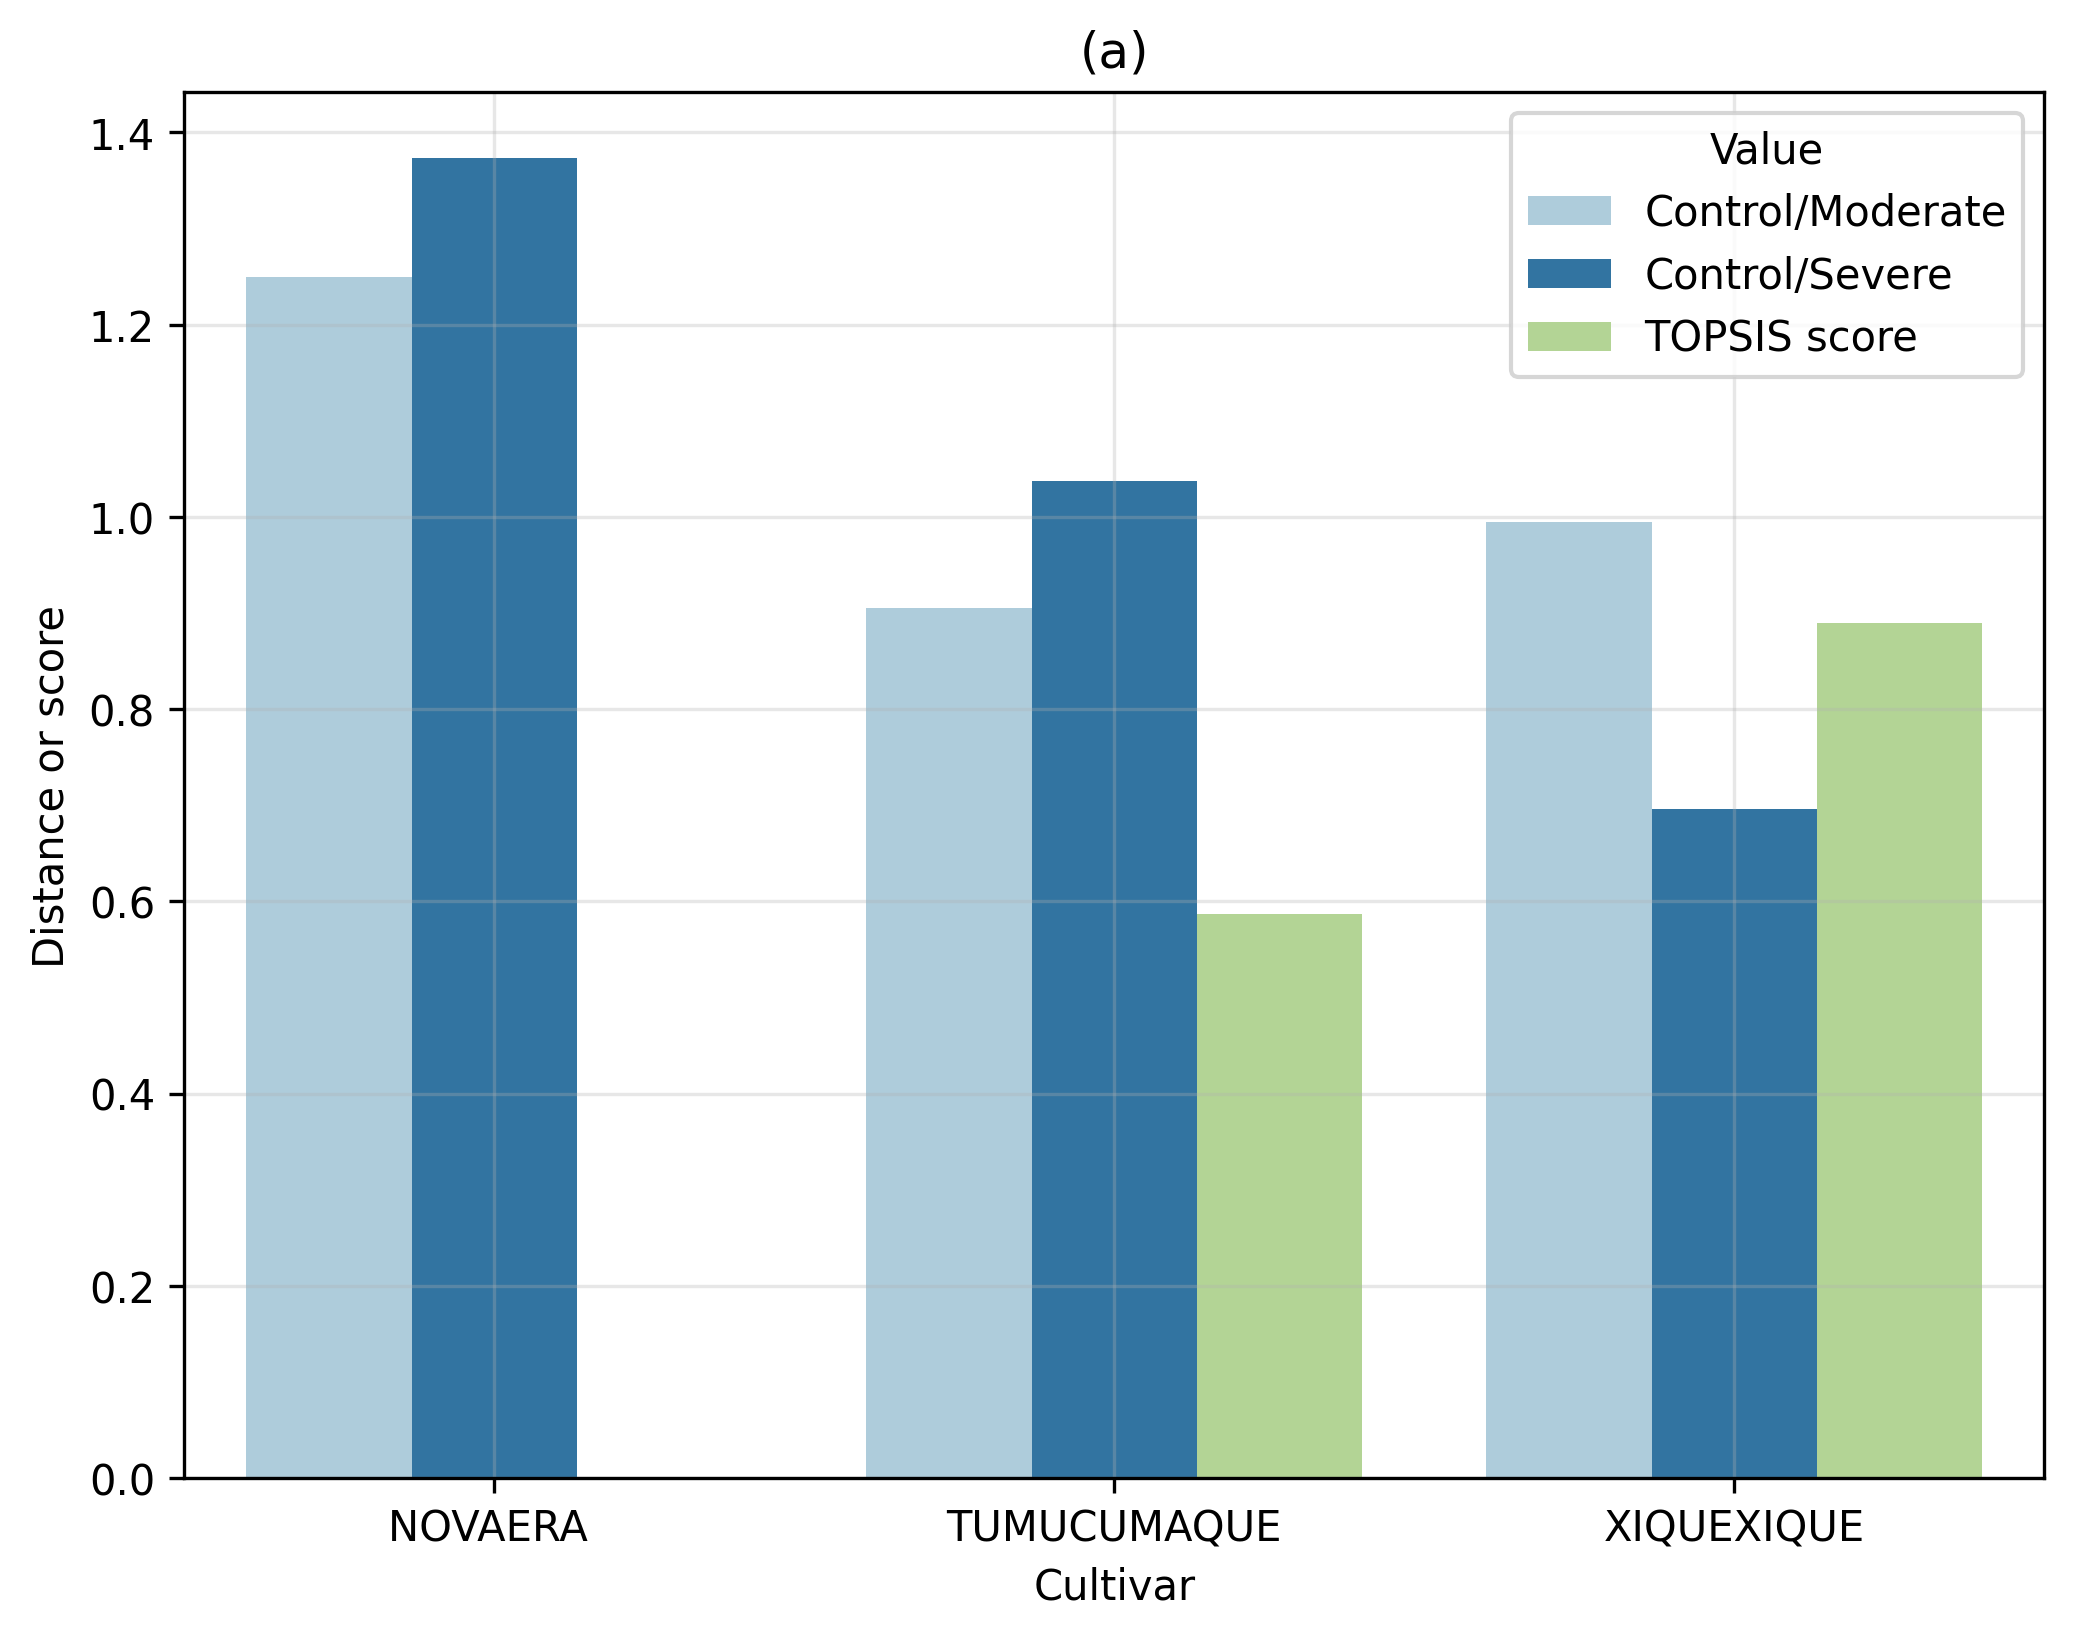

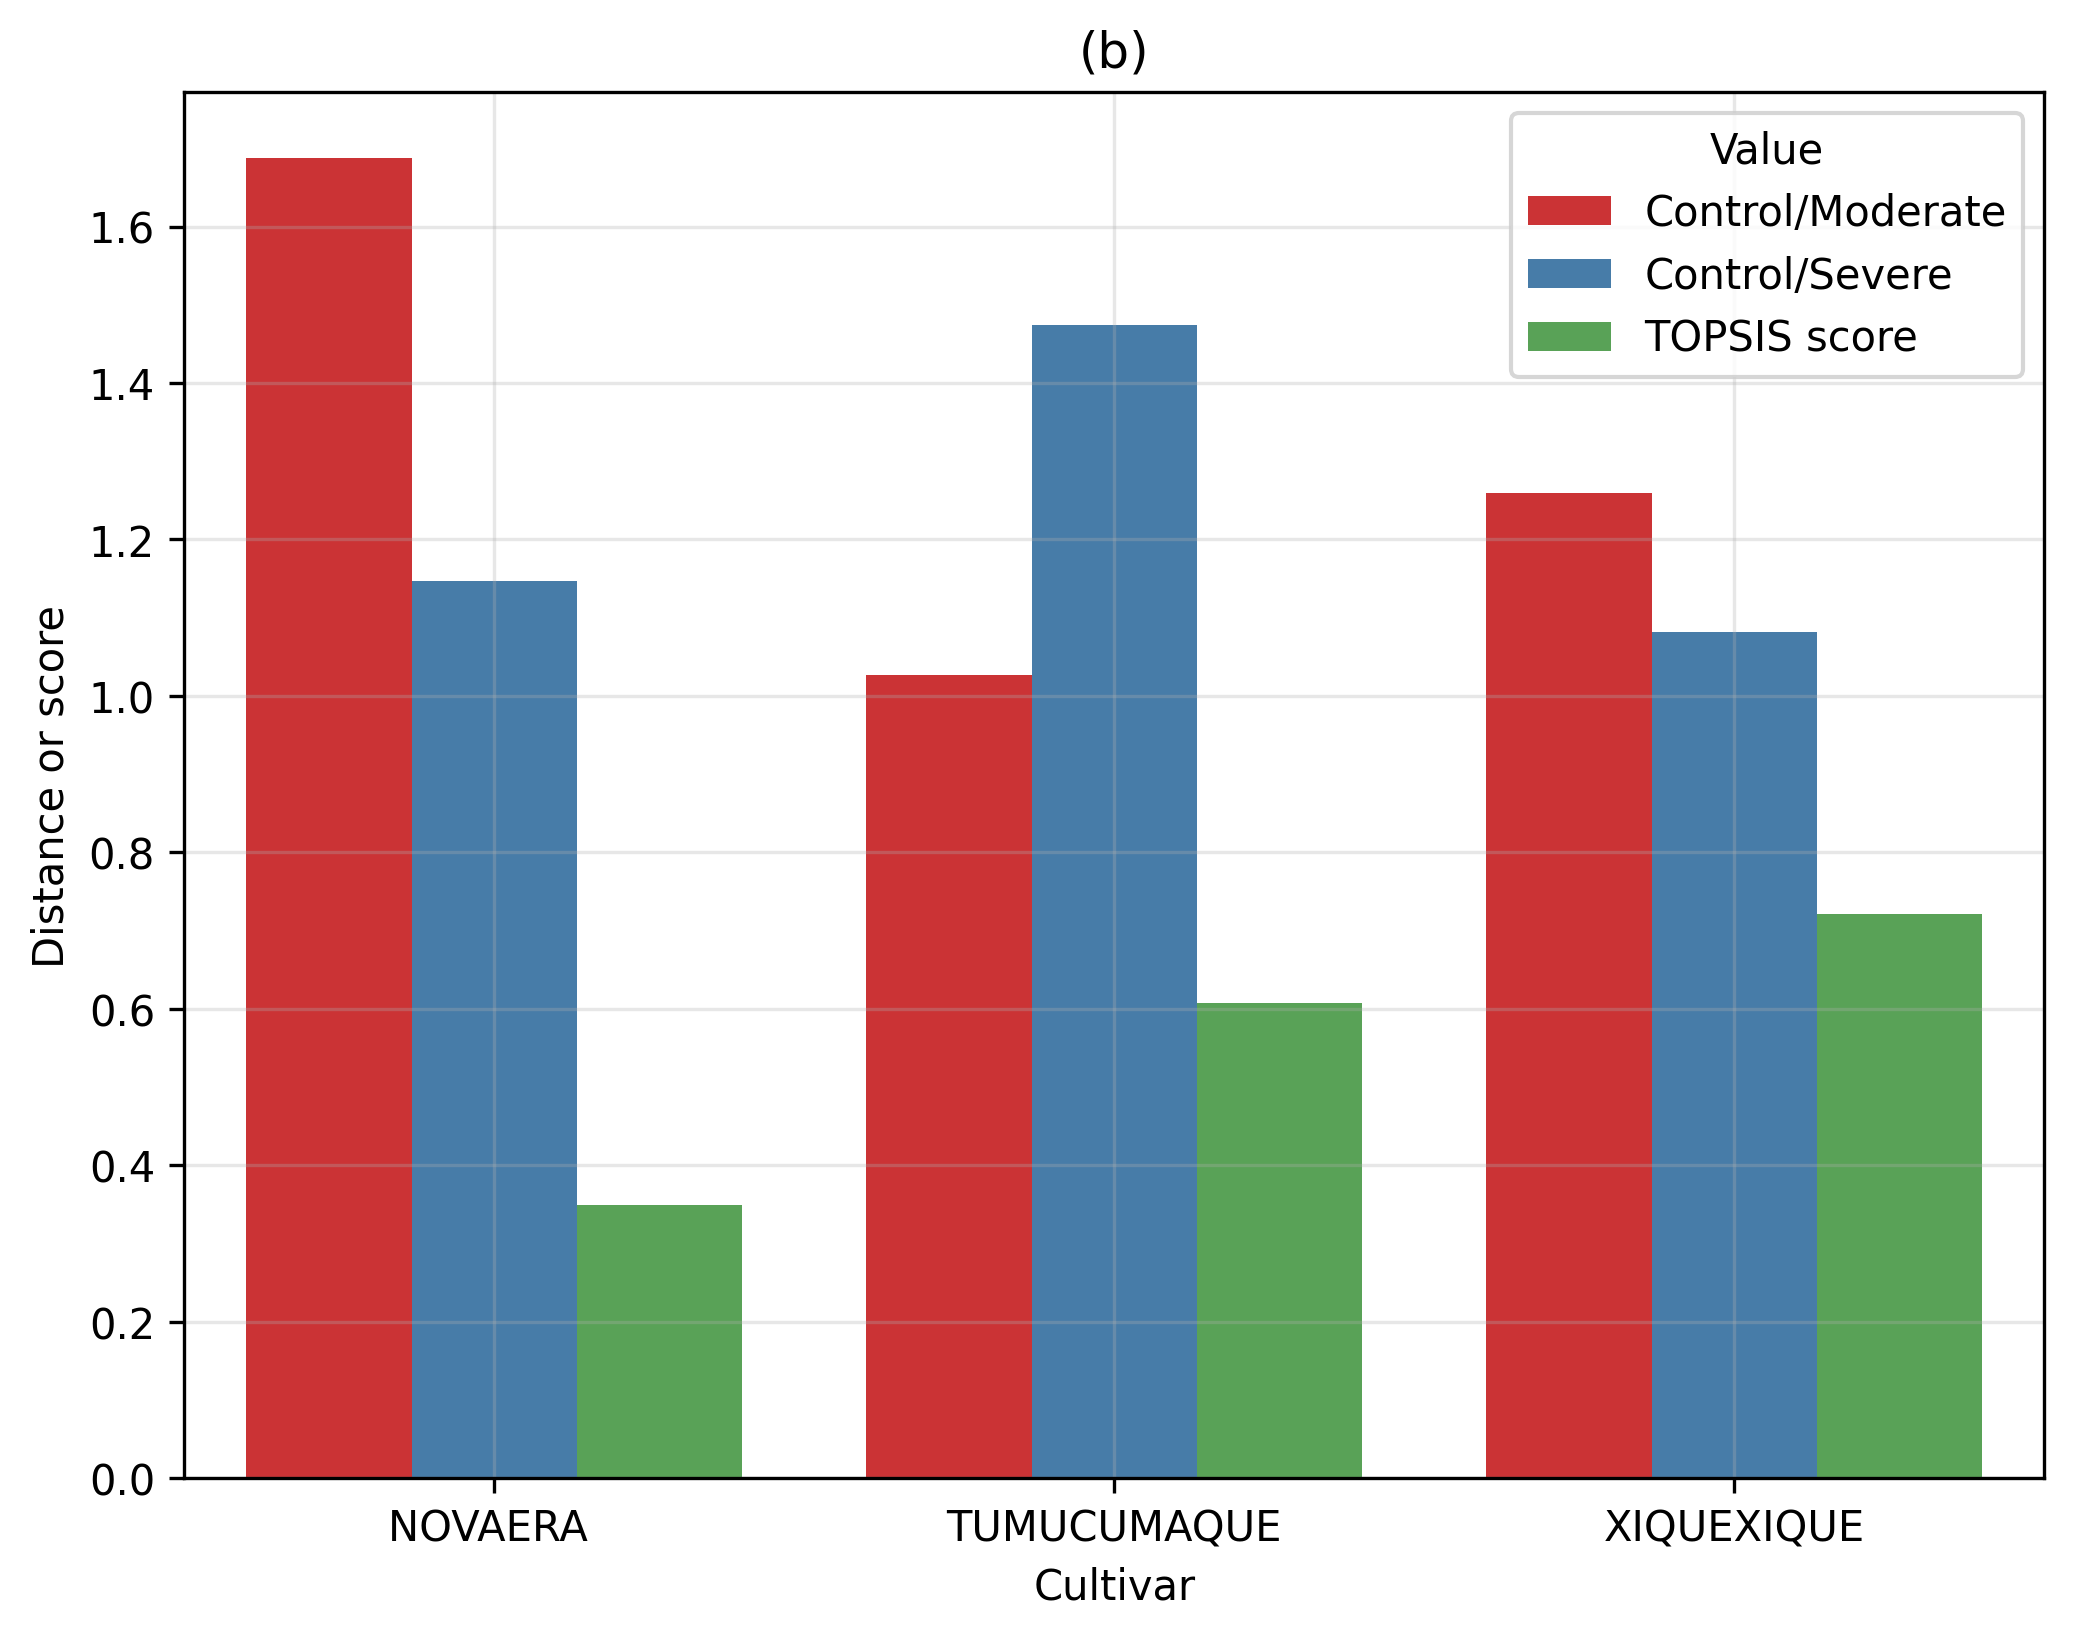

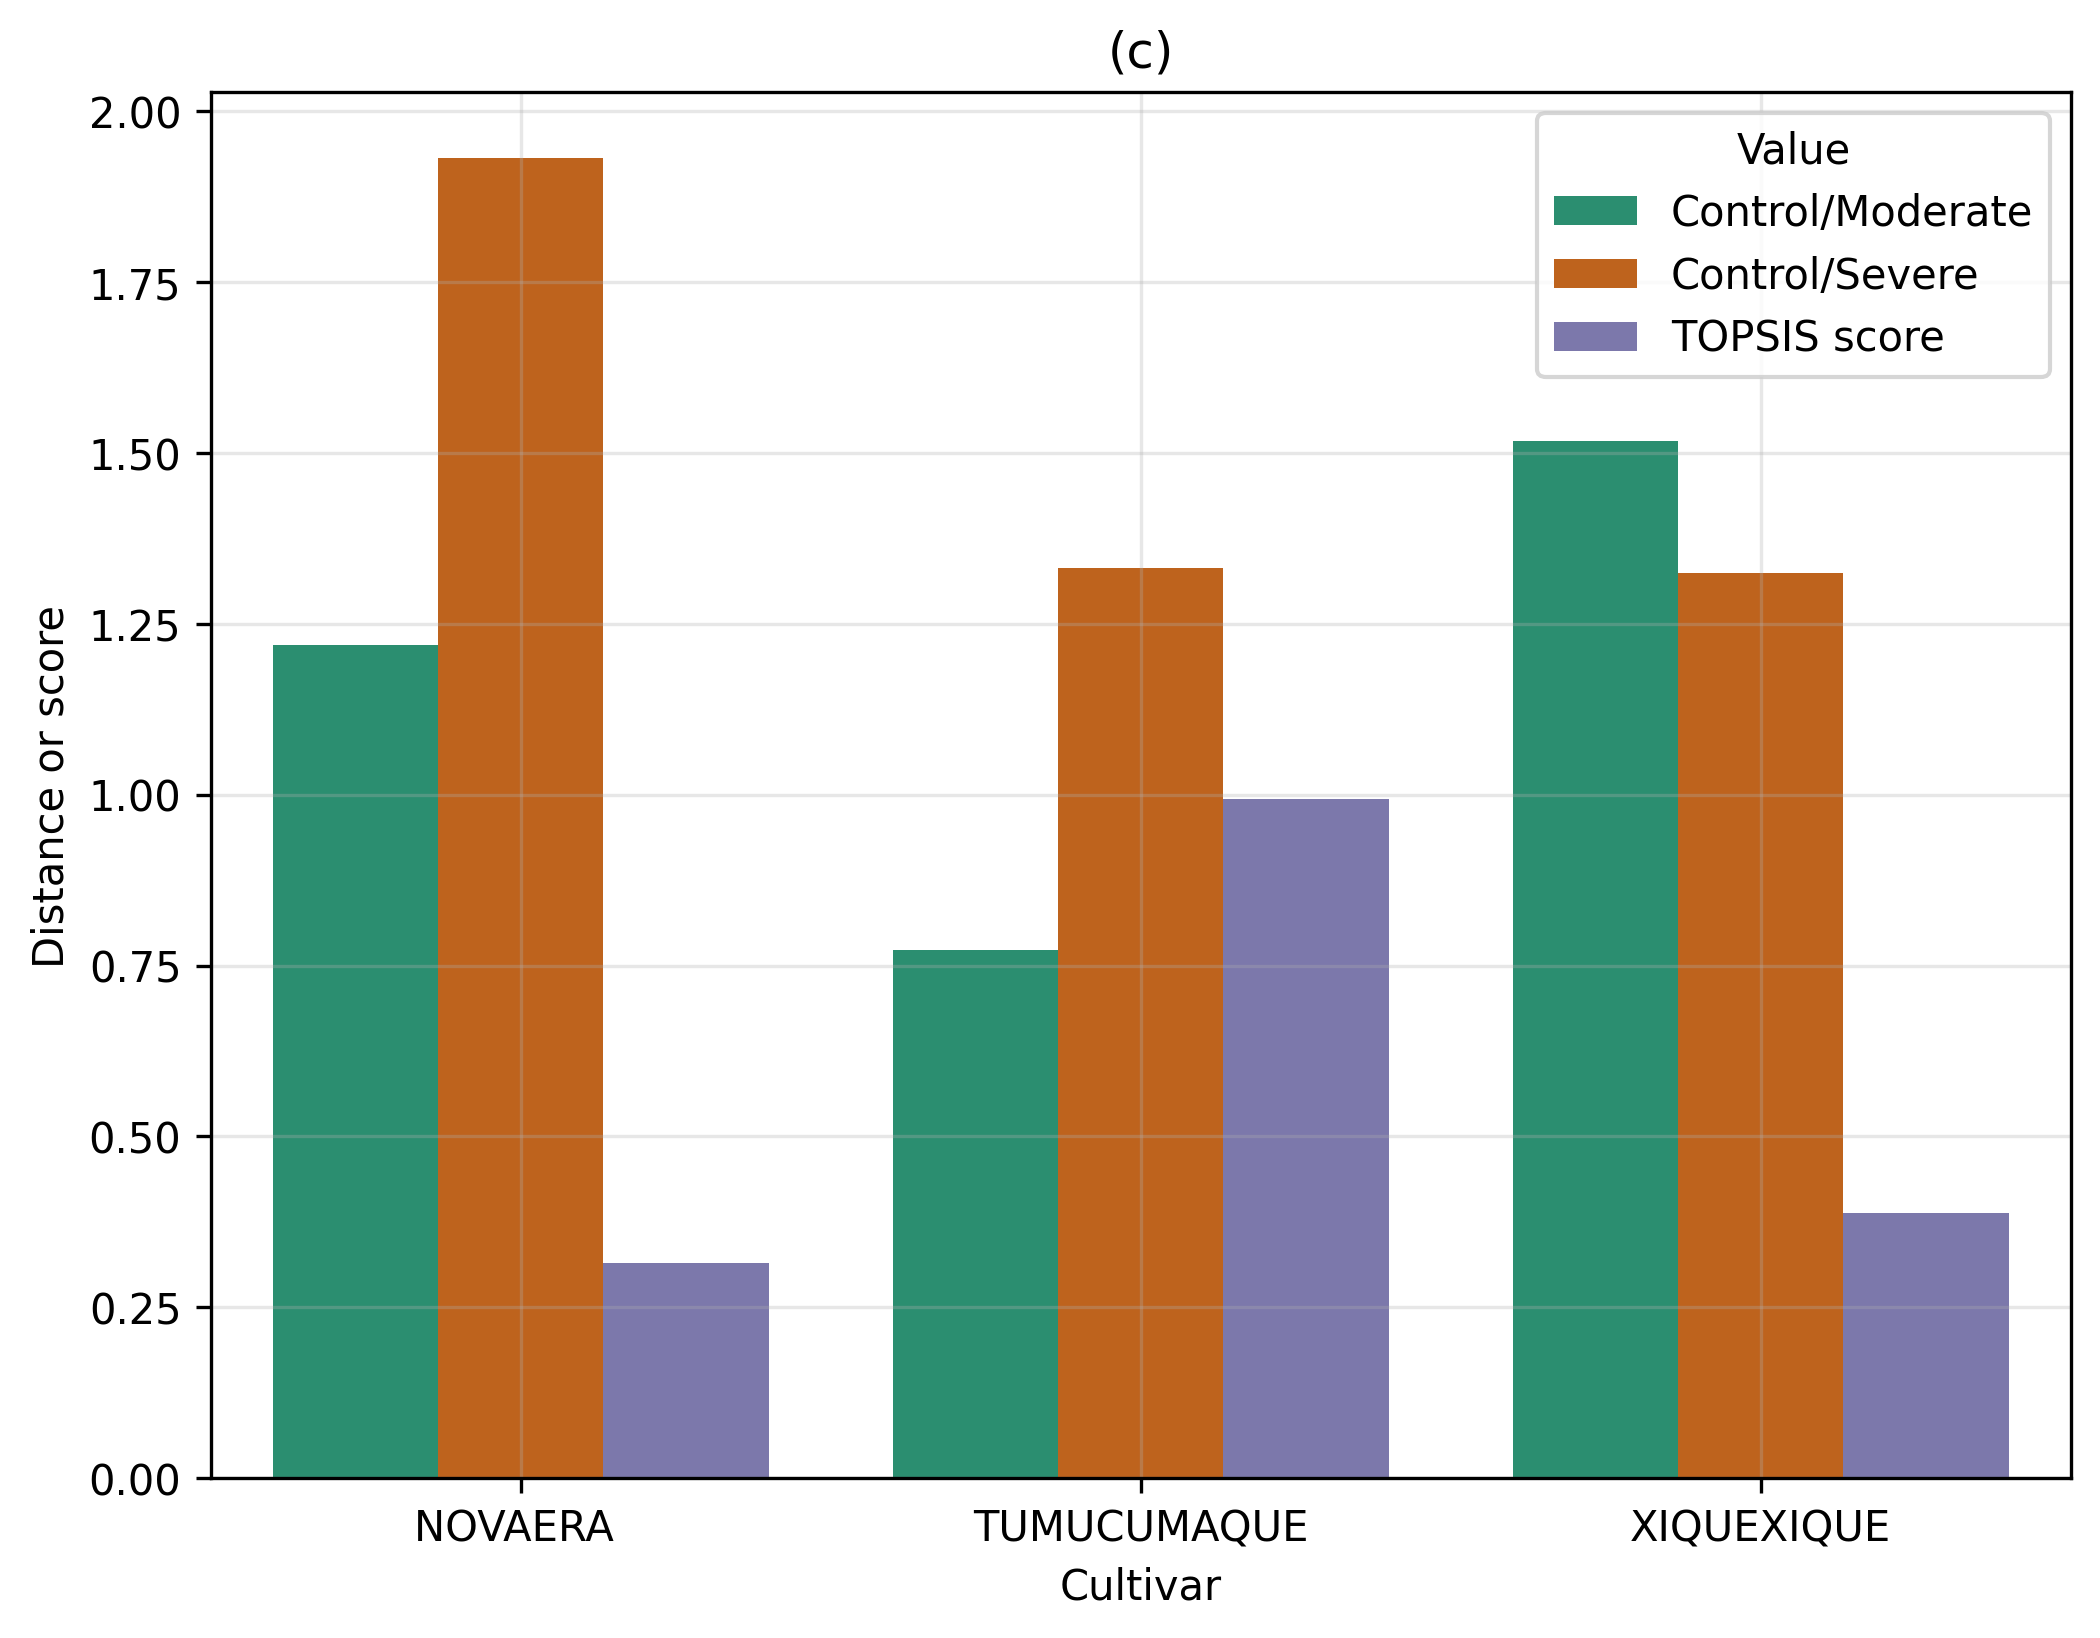

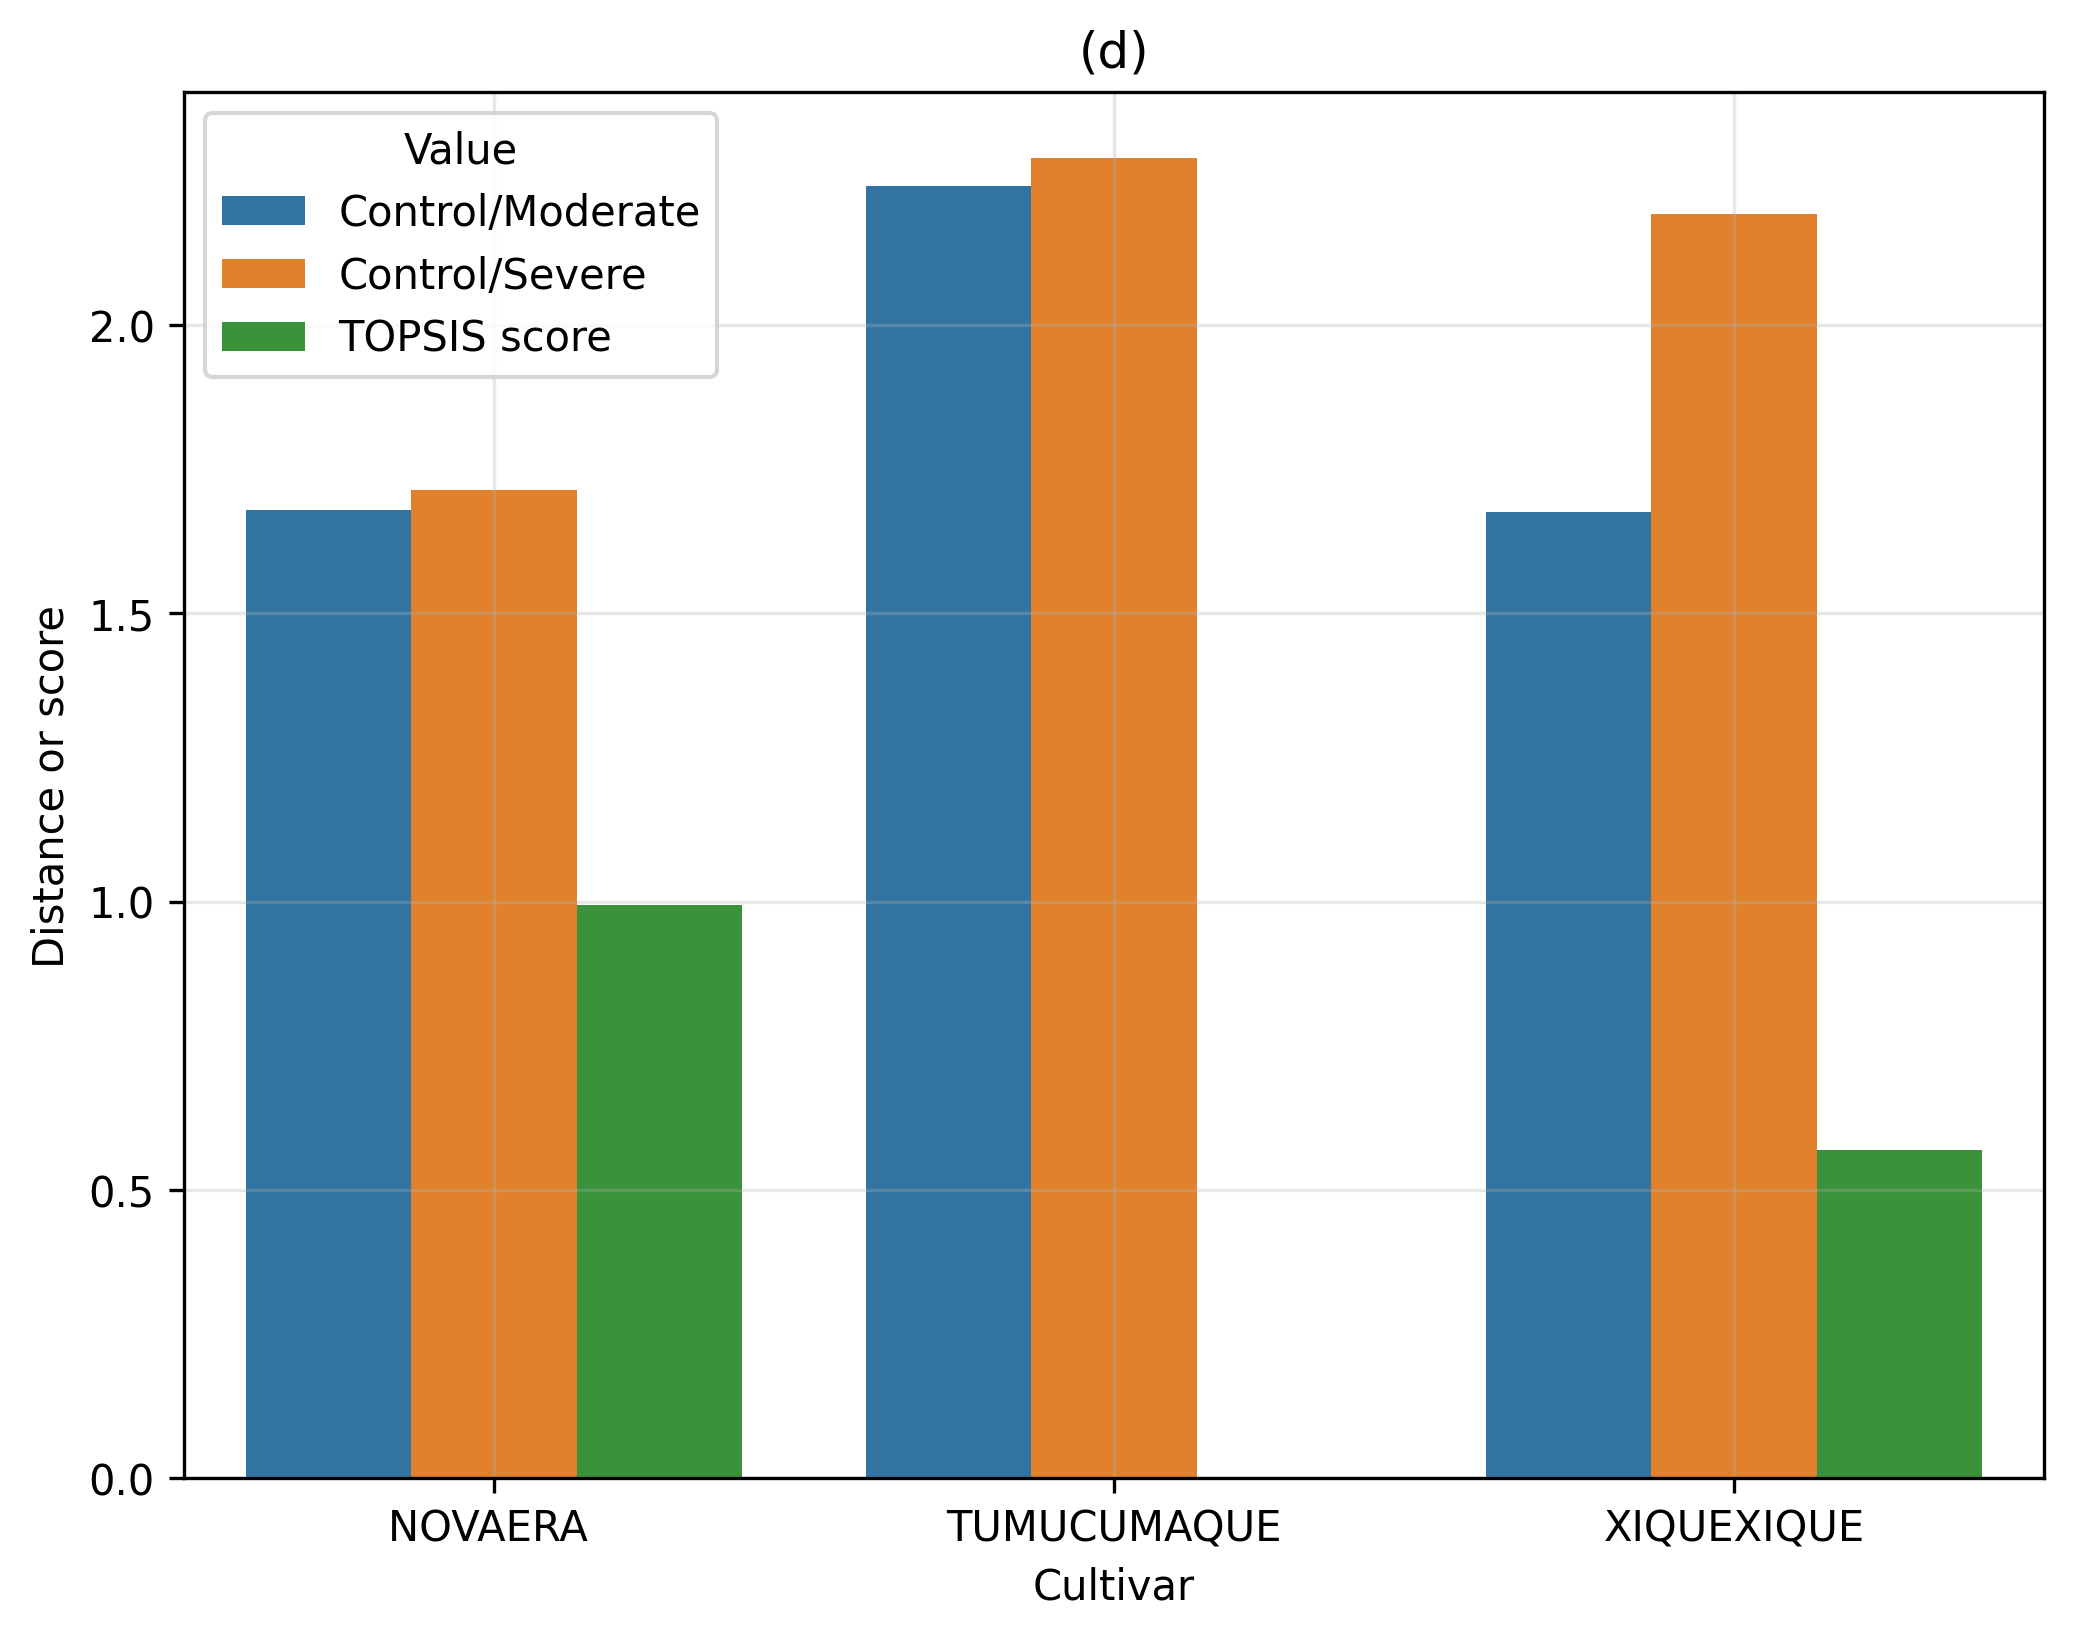

In [ ]:
#Bar chart with all values
letter  = ['a', 'b', 'c', 'd']
palette = ['Paired','Set1','Dark2','tab10']

for i, si_level in enumerate(si_levels):

    #print('\nSilicon level: ', si_level, '\n')

    plt.figure(dpi=300, figsize=(8,6))
    sns.set_palette(palette[i])
    sns.barplot(y='Measure', x='Cultivar', hue='Value', data=df_si_compare[i])
    plt.grid(alpha=0.3)
    #plt.ycorrlabel('Cultivar')
    plt.ylabel('Distance or score')
    plt.title('(' + letter[i] + ')')
    plt.show()

In [ ]:
#Varies the weights of the criteria (distances in each stressed environment)
#and check how topsis score changes to the 10 best cultivars

for i, si_level in enumerate(si_levels):

    print('\nSilicon level: ', si_level, '\n')

    distances_si = dists_si_level[i]

    for w_s in np.arange(0.1, 1, 0.2):
        # w_s is the weight for control/saline
        w_d = 1 - w_s #weight for control/drought

        #Apply TOPSIS with new weights
        decision = topsis(distances_si, [w_s, w_d], [0, 0])
        decision.calc()

        #Data with distances and similarities obtained by TOPSIS
        data = np.array([cultivars, decision.C]).T

        df_ = pd.DataFrame(data=data, columns=['Cultivar','TOPSIS Score'])

        print('Weight Control/Moderate: ', w_s)
        print(df_.sort_values(by=['TOPSIS Score'], ascending=False).head(10).to_string(index=False))
        convert_MSWord(df_.sort_values(by=['TOPSIS Score'], ascending=False).head(10), 'resultado_weight_' + str(w_s) + '_' + str(si_level))



Silicon level:  0 

Weight Control/Moderate:  0.1
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.985397
TUMUCUMAQUE     0.497821
   NOVAERA           0.0
Weight Control/Moderate:  0.30000000000000004
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.946554
TUMUCUMAQUE       0.5187
   NOVAERA           0.0
Weight Control/Moderate:  0.5000000000000001
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.889092
TUMUCUMAQUE     0.586575
   NOVAERA           0.0
Weight Control/Moderate:  0.7000000000000001
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.811182
TUMUCUMAQUE     0.720567
   NOVAERA           0.0
Weight Control/Moderate:  0.9000000000000001
   Cultivar TOPSIS Score
TUMUCUMAQUE     0.902391
 XIQUEXIQUE     0.748343
   NOVAERA           0.0

Silicon level:  1 

Weight Control/Moderate:  0.1
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.943144
   NOVAERA      0.777484
TUMUCUMAQUE     0.146813
Weight Control/Moderate:  0.30000000000000004
   Cultivar TOPSIS Score
 XIQUEXIQUE     0.823079
   NOVAERA      0.549